In [13]:
# #Selenium 4.9.0
# from selenium import webdriver
# from selenium.webdriver.edge.service import Service
# from selenium.webdriver.edge.options import Options as EdgeOptions
# from selenium.webdriver.common.keys import Keys
# from selenium.webdriver.common.by import By
# from selenium.common.exceptions import NoSuchElementException
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC

# import re
# import time
# from datetime import datetime
# import pandas as pd
# from concurrent.futures import ThreadPoolExecutor

# import nltk
# from nltk.corpus import stopwords
# from wordcloud import WordCloud

# import plotly.express as px
# import matplotlib.pyplot as plt

# pd.set_option('future.no_silent_downcasting', True)

# game_id = 291550
# url_template = "https://steamcommunity.com/app/{}/reviews/?p=1&browsefilter=mostrecent&filterLanguage=english"
# url = url_template.format(game_id)

# print(url)

# options = EdgeOptions()

# language = "en-US"
# options.add_argument(f"--lang={language}")

# service = Service("./msedgedriver.exe")
# driver = webdriver.Edge(service=service, options=options)
# driver.maximize_window()
# driver.get(url)

# def get_current_scroll_position(driver):
#     return driver.execute_script("return window.pageYOffset;")

# def scroll_to_bottom(driver):
#     driver.execute_script("window.scrollTo(0, document.body.scrollHeight * 2);")
#     time.sleep(0.5)

# def get_steam_id(card):
#     profile_url = card.find_element(By.XPATH, './/div[@class="apphub_friend_block"]/div/a[2]').get_attribute('href')
#     steam_id = profile_url.split('/')[-2]
#     return steam_id

# def scrape_review_data(card):
#     date_posted_element = card.find_element(By.XPATH, './/div[@class="apphub_CardTextContent"]/div[@class="date_posted"]')
#     date_posted = date_posted_element.text.strip()
    
#     try:
#         early_access_review_element = card.find_element(By.XPATH, './/div[@class="apphub_CardTextContent"]/div[@class="early_access_review"]')
#         early_access_review = early_access_review_element.text.strip()
#     except NoSuchElementException:
#         early_access_review = ""

#     try:
#         received_compensation_element = card.find_element(By.CLASS_NAME, "received_compensation").text
#     except NoSuchElementException:
#         received_compensation_element = ""

#     card_text_content_element = card.find_element(By.CLASS_NAME, "apphub_CardTextContent")
#     review_content = card_text_content_element.text.strip()
#     excluded_elements = [date_posted, early_access_review, received_compensation_element]

#     for excluded_element in excluded_elements:
#         review_content = review_content.replace(excluded_element, "")
#     review_content = review_content.replace("\n", "")

#     review_length = len(review_content.replace(" ", ""))

#     thumb_text = card.find_element(By.XPATH, './/div[@class="reviewInfo"]/div[2]').text
#     play_hours = card.find_element(By.XPATH, './/div[@class="reviewInfo"]/div[3]').text

#     return early_access_review, review_content, thumb_text, review_length, play_hours, date_posted

# def process_review(card):
#     steam_id = get_steam_id(card)
#     if steam_id not in steam_ids_set:
#         review = scrape_review_data(card)
#         steam_ids_set.add(steam_id)
#         return review
#     return None

# def process_reviews(driver):
#     cards = driver.find_elements(By.CLASS_NAME, 'apphub_Card')
#     with ThreadPoolExecutor(max_workers=10) as executor:
#         new_reviews = list(filter(None, executor.map(process_review, cards)))
#     return new_reviews

# def wait_for_reviews(driver):
#     WebDriverWait(driver, 10).until(
#         EC.presence_of_element_located((By.CLASS_NAME, 'apphub_Card'))
#     )

# reviews = []
# steam_ids_set = set()

# try:
#     while len(reviews) < 500:
#         wait_for_reviews(driver)
#         new_reviews = process_reviews(driver)
#         reviews.extend(new_reviews)
#         print(f"Collected {len(reviews)} reviews")
        
#         if len(reviews) >= 500:
#             break
        
#         scroll_to_bottom(driver)

# except Exception as e:
#     print(f"An error occurred: {e}")

# finally:
#     print(f"Total reviews collected: {len(reviews)}")
#     driver.quit()

# df = pd.DataFrame(reviews, columns=['EarlyAccess', 'ReviewText', 'Review', 'ReviewLength', 'PlayHours', 'DatePosted'])

# def clean_play_hours(x):
#     # Remove 'hrs on record' and any commas
#     cleaned = re.sub(r'[^\d.]', '', str(x))
#     # Convert to float
#     return float(cleaned) if cleaned else 0.0

# df['PlayHours'] = df['PlayHours'].apply(clean_play_hours)
# df['DatePosted'] = df['DatePosted'].map(lambda x: re.sub('Posted: ', '', x))

# month_mapping = {
#     'January': '01',
#     'February': '02',
#     'March': '03',
#     'April': '04',
#     'May': '05',
#     'June': '06',
#     'July': '07',
#     'August': '08',
#     'September': '09',
#     'October': '10',
#     'November': '11',
#     'December': '12',
# }

# df[['Day', 'Month']] = df['DatePosted'].str.extract(r'(\d+) (\w+)', expand=True)
# df['Month'] = df['Month'].map(month_mapping)

# df['DatePosted'] = df['Day'] + '/' + df['Month'] + '/2024'
# df['DatePosted'] = pd.to_datetime(df['DatePosted'], format='%d/%m/%Y').dt.strftime('%d-%m-%Y')
# df = df.drop(['Day', 'Month'], axis=1)

# df.to_csv('steam_reviews.csv', encoding='utf-8', sep=';', index=False)

import pandas as pd
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer

pd.set_option('future.no_silent_downcasting', True)

# Load the CSV file
df = pd.read_csv('steam_reviews.csv', sep=';', encoding='utf-8')

# Convert 'DatePosted' to datetime
df['DatePosted'] = pd.to_datetime(df['DatePosted'], format='%d-%m-%Y')

# Convert 'PlayHours' to float
df['PlayHours'] = df['PlayHours'].astype(float)

In [14]:
# Stopwords
def remove_stopwords(sentences, stopwords):
    filtered_words = [item for item in sentences if item not in stopwords]
    return ' '.join(filtered_words)

stopwords = stopwords.words('english')
df['cleanedReviewText'] = df['ReviewText'].astype(str).apply(lambda x: remove_stopwords(x.split(), stopwords))

# Tokenization
example = df['cleanedReviewText'][1]
tokens = nltk.word_tokenize(example)
tagged = nltk.pos_tag(tokens)

# Sentiment analysis
sie = SentimentIntensityAnalyzer()
df['PolarityScores'] = [sie.polarity_scores(x)['compound'] for x in df['cleanedReviewText']]

# Results
df['ReviewValue'] = df['Review'].replace({'Recommended': 1, 'Not Recommended': 0})

In [15]:
correlation = df[['ReviewValue', 'PolarityScores']].corr(method='pearson')
print("Correlation between ReviewValue and PolarityScores:")
print(correlation)

Correlation between ReviewValue and PolarityScores:
                ReviewValue  PolarityScores
ReviewValue        1.000000        0.372851
PolarityScores     0.372851        1.000000


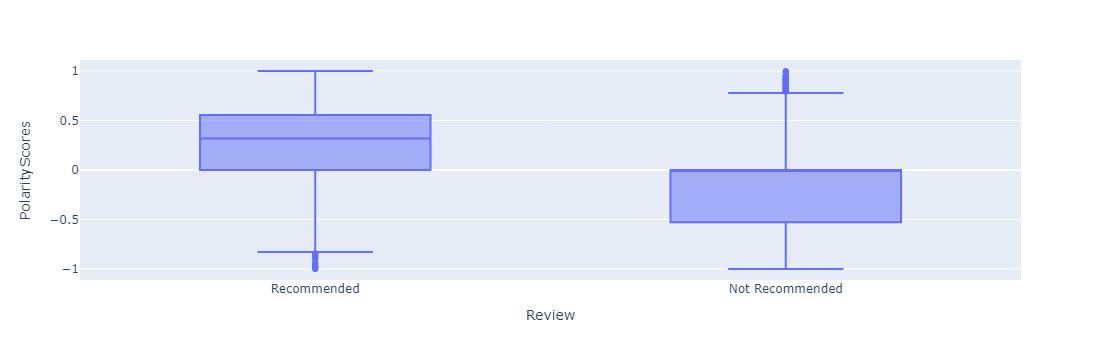

In [16]:
fig = px.box(df, x='Review', y='PolarityScores')
fig.show()

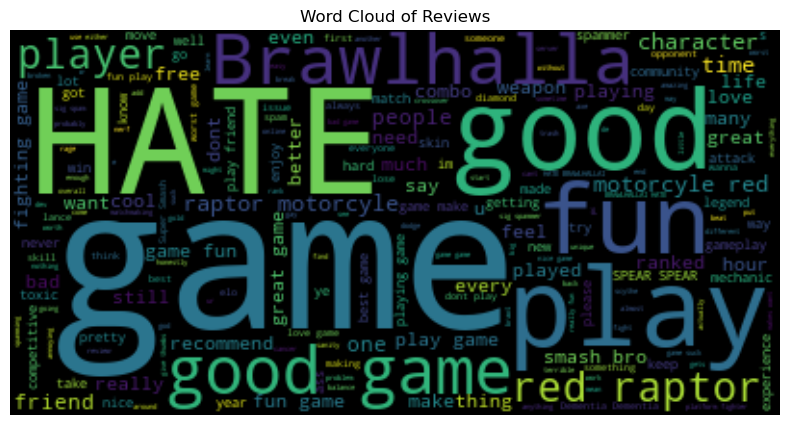

In [17]:
def plot_wordcloud(series, output_filename='wordcloud'):
    wordcloud = WordCloud().generate(' '.join(series.astype(str)))
    wordcloud.to_file(output_filename + '.png')
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud of Reviews")
    plt.show()

plot_wordcloud(df['cleanedReviewText'])

In [18]:
# reviews = []
# steam_ids_set = set()
# max_scroll_attempts = 5

# try:
#     last_position = get_current_scroll_position(driver)
#     running = True
#     while running:
#         cards = driver.find_elements(By.CLASS_NAME, 'apphub_Card')

#         for card in cards[-20:]:
#             steam_id = get_steam_id(card)
#             if steam_id in steam_ids_set:
#                 continue
#             else:
#                 review = scrape_review_data(card)
#                 reviews.append(review)

#         scroll_attempt = 0
#         while scroll_attempt < max_scroll_attempts:
#             scroll_to_bottom(driver)
#             curr_position = get_current_scroll_position(driver)

#             if curr_position == last_position:
#                 scroll_attempt += 1
#                 time.sleep(3)

#                 if curr_position >=3:
#                     running = False
#                     break
#             else:
#                 last_position = curr_position
#                 break
                
# except Exception as e:
#     print(e)

# finally:
#     driver.quit()
